# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle
Александр Журавлев DST-120   
**Aleksandr_DSSF** - профиль на Kaggle 

***

**Цель.** В этом модуле вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.  

Первоначальная версия датасета содержит 17 полей со следующей информацией:
- **hotel_address** — адрес отеля;
- **review_date** — дата, когда рецензент разместил соответствующий отзыв;
- **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- **hotel_name** — название отеля;
- **reviewer_nationality** — страна рецензента;
- **negative_review** — отрицательный отзыв, который рецензент дал отелю;
- **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
- **positive_review** — положительный отзыв, который рецензент дал отелю;
- **review_total_positive_word_counts** — общее количество слов в положительном отзыве;
- **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
- **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
- **total_number_of_reviews** — общее количество действительных отзывов об отеле;
- **tags** — теги, которые рецензент дал отелю;
- **days_since_review** — количество дней между датой проверки и датой очистки;
- **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- **lat** — географическая широта отеля;
- **lng** — географическая долгота отеля.

***

## 1. Импортируем библиотеки.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np

# для визуализации
import seaborn as sns
from matplotlib import pyplot as plt

# убрать предупреждения
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# для получения координат по названию города и страны
from geopy.geocoders import Nominatim

# для анализа текста
import nltk
# nltk.download()
#nltk.download('vader_lexicon')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn

# импортируем класс Counter из модуля collections
from collections import Counter

# импорт для работы с кодировщиком
import category_encoders as ce 

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# для нормализации, стандартизации
from sklearn import preprocessing

# Импортируем библиотеки для создания и обучения модели:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

***

## 2. Загрузка данных.

### 2.1. Загрузка данных с Kaggle.

In [4]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

### 2.2. Локальная загрузка данных.

In [5]:
DATA_DIR = 'sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

***

## 3. Знакомство с данными.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [10]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


***

## 4. Объединяем трейн и тест в один датасет.

In [12]:
# ВАЖНО! Для корректной обработки признаков объединяем трейн и тест в один датасет.
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

***
***

## 5. Предварительно оценим наш датасет.

In [13]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

***

## 6. Помечаем дубликаты, создав сигнальный признак **is_duplicated**

Насколько я понял, все-таки не рекомендуется удалять дубликаты. Да и само их удаление ухудшает мою метрику. Поэтому - пометим их новым сигнальным признаком.

In [14]:
# найдем дубликаты
hotels['is_duplicated'] = hotels.duplicated()

# приведем признак к числовому, заполнив его нулями и пометив дупликат 1
hotels['is_duplicated'] = hotels['is_duplicated'].astype(int)

# узнаем сколько дубликатов в датасете
duplicates_sum = hotels['is_duplicated'].sum()
print(f'Количество помеченных дубликатов: {duplicates_sum}')

Количество помеченных дубликатов: 336


## 7. Проверим корреляцию числовых признаков.

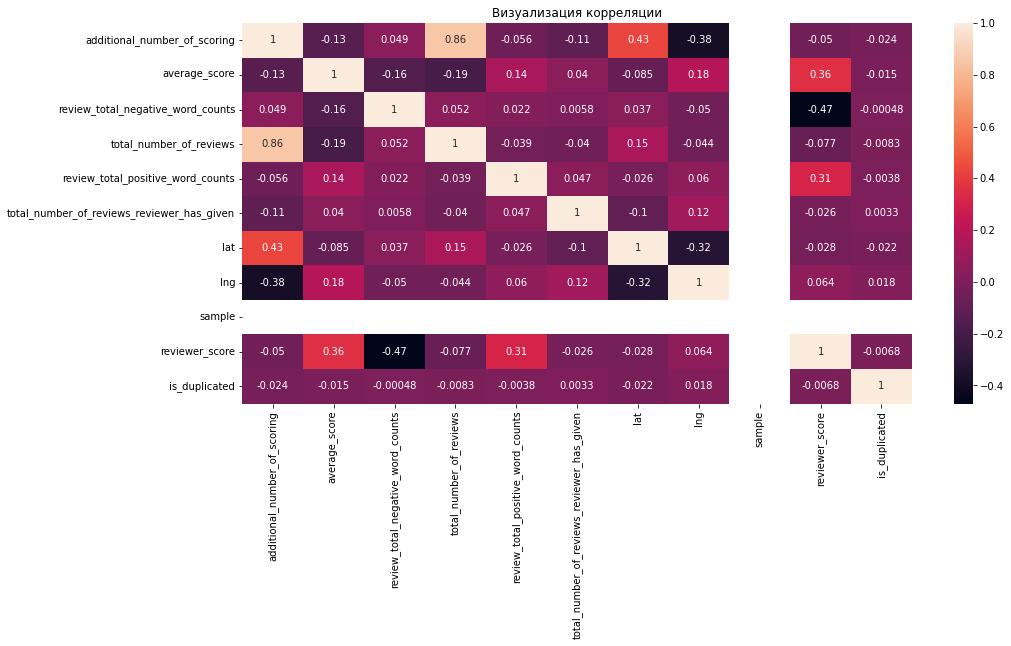

In [15]:
# построим тепловую матрицу корреляции категориальных числовых признаков
plt.figure(figsize=(15, 7))
heatmap = sns.heatmap(hotels[hotels['sample'] == 1].corr(method = 'spearman'), annot = True)
heatmap.set_title("Визуализация корреляции")
plt.show();

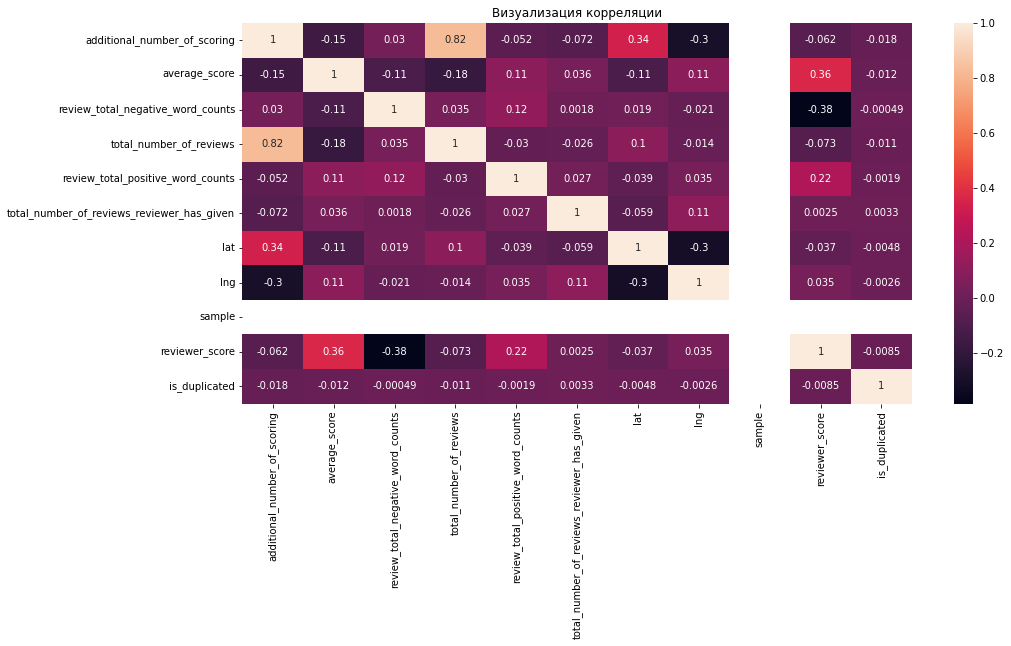

In [16]:
# построим тепловую матрицу корреляции непрерывных числовых признаков
plt.figure(figsize=(15, 7))
heatmap = sns.heatmap(hotels[hotels['sample'] == 1].corr(method = 'pearson'), annot = True)
heatmap.set_title("Визуализация корреляции")
plt.show();

**Выводы по основному датасету:**  
- В таблице имеется 17 признаков (без учета признака **sample**), числовых и категориальных.
- Пропуски имеются в столбцах с координатами отеля.
- Имеются 336 дубликатов (помечены).
- Если брать числовые признаки, то наш таргет показывает наиболее высокую положительную корреляцию с **average_score** и **review_total_positive_word_counts**, и отрицательную корреляцию с **review_total_negative_word_counts**. Что является вполне логичным. Однако, так же можно заметить, что корреляция с количеством слов отрицательных отзывов выше, чем с количеством положительных.

***
***

## 8. Последовательно работаем с признаками.

### 8.1. Признак **hotel_address** - адрес отеля.

In [17]:
hotels['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

В таблице с данными имеется 1493 адреса отеля. Из данного признака можно получить:  
- название страны
- название города
- регион
- почтовый индекс  
Дополнительно можно притянуть численность населения страны, где расположен отель.

#### 8.1.1. Получаем признак страны **hotel_country**, где расположен отель.

In [18]:
# составим список стран с названием в 2 отдельных слова, указав последнее слово
country_2_word_names = [
    'Congo', 'Kingdom', 'Africa', 'Korea', 'Arabia', 
    'Coast', 'Lanka', 'Faso', 'Sudan', 'Republic', 
    'Leone', 'Salvador', 'Rica', 'Zealand', 'Guinea', 'Timor', 
    'Islands', 'Sahara', ' Verde', 'Caledonia', 'Maarten', 'Martin'
]

# составим список стран с названием в 3 отдельных слова, указав последнее слово
country_3_word_names = [
    'Emirates', 'Herzegovina', 'Tobago', 'Barbuda'
]

# напишем функцию для получения названия страны из адреса отеля
def get_country_name(arg):
    '''
    функция возвращает название страны из адреса отеля
    :arg: аргументом является адрес отеля, полученный в виде строки, название страны в конце строки;
    :full_address_split: полученный аргумент разбиваем на список слов,
        в зависимости от последнего слова, составляем название страны,
        которое может быть составлено из несколько слов. Для этого прогоняем
        последнее слово списка full_address_split по соответствующим спискам выше;
    :country_name: полученное название страны возвращаем;
    '''
    full_address_split = arg.split(' ')
    if full_address_split[-1] in country_3_word_names:
        country_name = full_address_split[-3] + ' ' + full_address_split[-2] + ' ' + full_address_split[-1]
    elif full_address_split[-1] in country_2_word_names:
        country_name = full_address_split[-2] + ' ' + full_address_split[-1]
    else:
        country_name = full_address_split[-1]
        
    return country_name

# создадим искомый признак страны, где расположен отель
hotels['hotel_country'] = hotels['hotel_address'].apply(get_country_name)

Посмотрим, в каких странах расположены отели.

In [19]:
hotels['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

Итак, у нас только 6 стран.

#### 8.1.2. Получаем признак города **hotel_city**, где расположен отель.

In [20]:
# создадим признак города, где расположен отель
hotels.loc[hotels[hotels['hotel_country'] == 'United Kingdom'].index,'hotel_city'] = \
    hotels['hotel_address'].apply(lambda x: x.split(' ')[-5])
hotels.loc[hotels[hotels['hotel_country'] != 'United Kingdom'].index,'hotel_city'] = \
    hotels['hotel_address'].apply(lambda x: x.split(' ')[-2])

Посмотрим, в каких городах расположены отели.

In [21]:
hotels['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

Городов только 6, как и количество стран.

#### 8.1.3. Получаем признак региона отеля **hotel_region**. 

In [22]:
# составим список городов в адресах отеля
city_list = ['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan']

# напишем функцию для получения названия региона из адреса отеля
def get_region(arg):
    '''
    функция возвращает название региона из адреса отеля
    :arg: аргументом является адрес отеля, полученный в виде строки;
    :full_address_split: полученный аргумент разбиваем на список слов, 
        перебираем его и склеиваем в строку,
        проверяем, чтобы в элементе списка не было цифр (тогда его убираем),
        как только дойдем до названия города - перебор прекращаем;
    :region_name: полученное название региона возвращаем;
    '''
    full_address_split = arg.split(' ')
    region_name = ''
    for i in range(len(full_address_split)):
        if full_address_split[i] not in city_list:
            if any(map(str.isdigit, full_address_split[i])):
                region_name = region_name
            else:
                region_name = region_name + full_address_split[i] + ' '
        else:
            return region_name

# получаем признак региона, где расположен отель        
hotels['hotel_region'] = hotels['hotel_address'].apply(get_region)

In [23]:
hotels['hotel_region'].value_counts()

Strand Westminster Borough                4796
Marsh Wall Docklands Tower Hamlets        4789
Inverness Terrace Westminster Borough     4279
Westminster Bridge Road Lambeth           4253
Pepys Street City of                      3601
                                          ... 
Via Palmanova                               12
Filmteichstra e Favoriten                   12
Rue Fran ois Ory                            10
Via M Buonarroti Fiera Milano City          10
Johann Staud Stra e Ottakring                8
Name: hotel_region, Length: 1247, dtype: int64

#### 8.1.4. Создадим признак **hotel_postcode** куда поместим почтовый индекс отеля.

In [24]:
# напишем функцию для получения почтового индекса из адреса отеля
def get_postcode(arg):
    '''
    функция возвращает почтовый индекс из адреса отеля
    :arg: аргументом является адрес отеля, полученный в виде строки;
    :full_address_split: полученный аргумент разбиваем на список слов и 
                         по шаблону находим почтовый индекс;
    :postcode: полученный почтовый индекс; 
    '''
    full_address_split = arg.split(' ')
    if full_address_split[-1] == 'Kingdom' or full_address_split[-1] == 'Netherlands':
        postcode = full_address_split[-4] + ' ' + full_address_split[-3]
    else:
        postcode = full_address_split[-3]
        
    return postcode

# получаем почтовый индекс
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

In [25]:
hotels['hotel_postcode'].value_counts()

1010       12440
20124      11726
75008      11119
08002      10174
75001       5539
           ...  
20141         22
1230          21
1017 JW       17
E2 7DD        12
92120         10
Name: hotel_postcode, Length: 601, dtype: int64

**Выводы:**  
- создан новый признак **hotel_country** - страна, где расположен отель
- создан новый признак **hotel_city** - город, где расположен отель
- создан новый признак **hotel_region** - регион, где расположен отель
- создан новый признак **hotel_postcode** - почтовый индекс отеля
- всего 1492 отеля (по названиям), расположенных по 1493 адресам, в 1247 регионах, в 6 странах и 6 городах; всего 601 почтовых индексов отеля
- в одном из вариантов решения я добавлял признак населения страны, где расположен отель и пробовал его оставлять как числовой признак или кодировать, как категориальный признак - ощутимого прироста качества метрики, к сожалению, я не получил.

***

#### 8.2. Признаки **lat** и **lng** - координаты отеля.

In [26]:
# получаем города с пропущенными значениями координат
hotels[hotels.isnull().any(1)]['hotel_city'].value_counts()

Vienna       2679
Paris         382
Barcelona     207
Name: hotel_city, dtype: int64

In [27]:
# заменяем пропущенные координаты отелей координатами городов, в которых они расположены
# координаты получим, используя сервис geopy

nominatim = Nominatim(user_agent='user')

# последовательно заполняем пропуски в координатах соответсвущих городам Вена, Париж, Барселона
hotels.loc[(hotels['hotel_city'] == 'Vienna') & (pd.isnull(hotels['lat'])), 'lat'] = float(nominatim.geocode('Vienna, Austria').raw['lat'])
hotels.loc[(hotels['hotel_city'] == 'Vienna') & (pd.isnull(hotels['lng'])), 'lng'] = float(nominatim.geocode('Vienna, Austria').raw['lon'])

hotels.loc[(hotels['hotel_city'] == 'Paris') & (pd.isnull(hotels['lat'])), 'lat'] = float(nominatim.geocode('Paris, France').raw['lat'])
hotels.loc[(hotels['hotel_city'] == 'Paris') & (pd.isnull(hotels['lng'])), 'lng'] = float(nominatim.geocode('Paris, France').raw['lon'])

hotels.loc[(hotels['hotel_city'] == 'Barcelona') & (pd.isnull(hotels['lat'])), 'lat'] = float(nominatim.geocode('Barcelona, Spain').raw['lat'])
hotels.loc[(hotels['hotel_city'] == 'Barcelona') & (pd.isnull(hotels['lng'])), 'lng'] = float(nominatim.geocode('Barcelona, Spain').raw['lon'])

**Выводы:** 
- отели с пропущенными координатами расположены в 3-х городах - Вена, Париж и Барселона
- вместо пропущенных координат отелей мы внесли координаты городов, в которых они расположены
- к сожалению, использовал эти данные для обучения модели как числовые признаки и как категориальные - особого прироста метрики не получил. Пробовал использовать расстояние от отеля до центра города, как мои коллеги - с тем же результатом. По итогу признаки удалил.

***

### 8.3. Признак **review_date** - дата размещения отзыва рецензентом. 

#### 8.3.1. Приведем признак к типу datetime.

In [28]:
# приведем к типу datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

#### 8.3.2. Получим признак **review_month** - месяц написания отзыва.

In [29]:
hotels['review_month'] = hotels['review_date'].dt.month

#### 8.3.3. Получим признак **review_dayofweek** - день недели написания отзыва.

In [30]:
hotels['review_dayofweek'] = hotels['review_date'].dt.dayofweek

**Выводы:**
- создан признак **review_month** - месяц написания отзыва
- признак **review_dayofweek** - день недели написания отзыва

**Примечание:** Я дополнительно получал признаки года, день месяца и день года, а так же группировал по месячным периодам - по итогу удалил эти признаки, т.к. метрика ухудшалась.

***

### 8.4. Признак **hotel_name** - название отеля.

In [31]:
hotels['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Eitlj rg                                         12
Hotel Daniel Paris                                     12
Mercure Paris Porte d Orleans                          10
Hotel Wagner                                           10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64

**Примечание:** Вообще странно, отелей 1492, а адресов 1493... Попробуем поискать дубликаты в названиях отелей.

In [32]:
hotels_grouped = hotels[['hotel_address', 'hotel_name']].groupby(['hotel_name']).nunique()
hotels_grouped[hotels_grouped['hotel_address'] > 1]

,hotel_address
hotel_name,
Hotel Regina,3


Ага, нашли. Отель с названием **Hotel Regina** дублируется. Изучим его более подробно.

In [33]:
mask = hotels['hotel_name'] == 'Hotel Regina'
hotels[mask][['hotel_name', 'hotel_address']].value_counts()

hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

Мои коллеги предлагают добавить в навание отеля город, тогда это поможет убрать дубликаты названий. Можно также добавить название страны. Воспользуемся решением уважаемого [ECO 189](https://www.kaggle.com/code/eco189/project-3-1/notebook?scriptVersionId=105582270)

In [34]:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] == 'Hotel Regina')
    else row['hotel_name'], axis=1)

In [35]:
hotels['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Daniel Paris                                     12
Boundary Rooms Suites                                  12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1494, dtype: int64

Теперь вылезла другая проблема - отелей стало 1494, но адресов у нас 1493. Ищем дубликаты адресов.

In [36]:
hotels_grouped = hotels[['hotel_address', 'hotel_name']].groupby(['hotel_address']).nunique()
hotels_grouped[hotels_grouped['hotel_name'] > 1]

,hotel_name
hotel_address,
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,2


In [37]:
mask = hotels['hotel_address'] == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'
hotels[['hotel_name','lat', 'lng']][mask].value_counts()

hotel_name                            lat        lng      
Club Quarters Hotel Trafalgar Square  51.506935  -0.126012    945
The Grand at Trafalgar Square         51.506935  -0.126012    733
dtype: int64

Очень странная ситуация. Два отеля с разными именами, но с одинаковыми адресами и координатами. Пришлось гуглить и сходить на Booking - действительно, есть два таких отеля. Ладно, просто их оставим, как есть и перейдем к следующему признаку.

**Выводы:**
- обнаружены дубликаты отеля Hotel Regina, которые расположены в разных городах (странах). От дубликатов избавились, добавив в названия отелей город, где они расположены.
- обнаружено 2 отеля, которые расположены по одному адресу. Такие отели действительно существуют, решено их оставить без изменений.

***

### 8.5. Признак **reviewer_nationality** - страна рецензента.  

#### 8.5.1 Предварительная обработка признака.

In [38]:
# очистим от пробелов края строк данного признака
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x.strip()
)

#### 8.5.2. Создадим новый признак **hotel_reviewer_same_country**, где будет отмечено совпадает ли страна расположения отеля со страной ревьювера.

In [39]:
# создадим новый признак - совпадает ли страна отеля и ревьювера

hotels['hotel_reviewer_same_country'] = hotels['hotel_country'] == hotels['reviewer_nationality']
hotels['hotel_reviewer_same_country'] = hotels['hotel_reviewer_same_country'].apply(
    lambda x: 1 if x is True else 0)

#### 8.5.3. Выделим отдельно англоязычные страны и страны ближнего востока, создав признаки **reviewer_en** и **reviewer_n_est**.

Удивительно, но эти признаки существенно улучшают метрику. Мне это в голову не пришло, но спасибо еще раз [ECO 189](https://www.kaggle.com/code/eco189/project-3-1/notebook?scriptVersionId=105582270) за блестящую идею!

In [40]:
# Выделим основные англоязычные страны:
english_list = ['United Kingdom', 
                'United States of America', 
                'Australia',
                'Ireland', 
                'Canada', 
                'New Zealand']
hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in english_list else 0)


# Выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar']
hotels['reviewer_n_est'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in muslim_list else 0)

**Выводы:**
- создан признак **hotel_reviewer_same_country**, где помечено совпадение страны расположения отеля и национальности ревьювера.
- добвлены признаки **reviewer_en** и **reviewer_n_est**, где отмечены ревьюверы с англоязычных и ближневосточных стран.   

**Примечание:** я дополнительно создавал признак, который бы отмечал европейских ревьюверов (с включением и исключением ревьюверов из стран расположения отелей), но из-за ухудшения метрики удалил. Возможно, причиной тому стал уже созданный признак **hotel_reviewer_same_country**.

***

### 8.6. Признак **negative_review** - негативный отзыв.

In [41]:
# напишем функцию, котрая будет обрабатывать отзывы
def review_processing(arg):
    '''
    :arg: аргумент функции - отзыв в виде строки;
    функция выполняет обрезку строки отзыва по краям, 
    очистку текста от знаков препинания и чисел, 
    преводит слова в нижний регистр;
    :review: возвращает обработанный отзыв в виде строки
    '''
    # обрезаем края строки отзыва
    arg = arg.strip()
    # очищаем текст
    review = re.sub('[^a-zA-Z]', ' ', arg)
    # переводим слова в нижний регистр
    review = arg.lower()
    
    return review

In [42]:
# обработаем негативные отзывы
hotels['negative_review'] = hotels['negative_review'].apply(review_processing)

Часть негативных отзывов не являются негативными. Попробуем их обозначить, вручную перебрав их (я взял 220 наиболее часто встречаемых отзывов).

In [43]:
# в этом списке будут негативные отзывы, которые на самом деле не содержат негатива
list_negive_review_no_negative = ['', ' ', 'no negative', 'nothing', 'n a', 'none', 'nothing really', 'all good', 'no complaints', 'nothing at all',
        'nothing to dislike', 'nil', 'everything was perfect', 'na', 'can t think of anything', 'leaving, absolutely nothing',
        'everything was great', 'nothing to complain about', 'no', 'nothing all good', 'having to leave', 
        'not much', 'i liked everything, everything was good', 'liked everything', 'nothing it was perfect', 'non',
        'nothing everything was perfect', 'nothing in particular', 'everything was fine', 'nothing everything was great', 
        'not applicable', 'all was good', 'nothing comes to mind', 'there was nothing i didn t like', 'not a thing', 
        'nothing i didn t like', 'no negatives', 'we liked everything', 'no complaints at all', 'no thing, nothing to report', 
        'all ok', 'there was nothing to dislike', 'it was all good', 'there was nothing we didn t like', 
        'loved everything', 'nothing i can think of', 'no dislikes', 'nothing to say', 'nothing to mention', 'nothing to complain', 'no issues', 
        'there was nothing not to like', 'no comment', 'everything was ok', 'everything was excellent', 'no problems', 'nothing we didn t like', 
        'nada', 'nothing special', 'nothing bad to say', 'liked it all', 'nothing could have been better', 'i loved everything', 'all great', 
        'nothing to not like', 'couldn t fault it', 'going home', 'nothing it was all good', 'no comments', 'nothing much', 'that we had to leave', 
        'nothing it was great', 'it was perfect', 'not a lot, nothing to fault', 'there wasn t anything we didn t like', 'what s not to like', 
        'loved it all', 'cannot think of anything', 'nothing negative to say', 'nothing all was good, no bad experiences', 'i liked it all', 
        'nothing all was great', 'all was great', 'that we couldn t stay longer', 'nothing that i can think of', 'that i couldn t stay longer', 
        'nothing it was all great', 'nothing of note', 'nothing all great', 'all was perfect', 'i can t think of anything', 'it was all great']

# правим признак negative_review, заменяя ложные негативные отзывы на none
hotels['negative_review'] = hotels['negative_review'].apply(
        lambda x: 'none' if x in list_negive_review_no_negative else x)

Создадим новый признак **negive_review_no_negative**, где ложные негативные отзывы будут отмечены.

In [44]:
hotels['negative_review_no_negative'] = hotels['negative_review'].apply(
    lambda x: 1 if x == 'none' else 0)

***

### 8.7. Признак **review_total_negative_word_counts** - число слов в негативном отзыве. 

После обработки отрицательных отзывов, количество слов в них должно измениться. Обновим значения признака.

In [45]:
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(
    lambda x: len(x.split(' ')))

***

### 8.8. Признак **positive_review** - положительный отзыв.

Здесь также имеются отзывы, которые на самом деле не являются положительными. Обработаем их вручную.

In [46]:
# сначала обработаем положительные отзывы, используя нашу функцию
hotels['positive_review'] = hotels['positive_review'].apply(review_processing)

In [47]:
# в этом списке будут позитивные отзывы, которые на самом деле негативные
list_positive_review_no_positive = ['', ' ', 'no positive', 'nothing', 'location only', 'not much', 
                                    'only the location', 'only location', 'not a lot',
                                    'nothing at all', 'n a', 'leaving', 'nothing special']

# правим признак positive_review
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'none' if x in list_positive_review_no_positive else x)

Создадим новый признак **positive_review_no_positive**, где ложные позитивные отзывы будут отмечены.

In [48]:
hotels['positive_review_no_positive'] = hotels['positive_review'].apply(lambda x: 1 if x == 'none' else 0)

***

### 8.9. Признак **review_total_positive_word_counts** - число слов в позитивном отзыве.

Также, как и с **review_total_negative_word_counts** обновим значения признака.

In [49]:
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: len(x.split(' ')))

**Выводы:**
- были обработаны признаки **negative_review** и **positive_review**: убраны пробелы по краям строк, буквы приведены к строчным, убраны знаки препинания и пр.
- с учетом вышеизложенного, признаки **review_total_negative_word_counts** и **review_total_positive_word_counts** были обновлены
- созданы признаки **negative_review_no_positive** и **positive_review_no_positive**, в которых отмечены отзывы, которые находятся среди позитивных (или негативных), но не являются таковыми.

***

### 8.10. Признак **tags** - теги, которые рецензент дал отелю. 

In [50]:
hotels['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                   5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                            3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                  3291
                                                                                                                                                          ... 
[' Leisure trip ', ' Couple ', ' Superior Quee

Всего у нас более 2тыс. тегов. Макисимальное количество указанных тегов - 6. Создадим новые признаки и разделим по ним теги.

#### 8.10.1. Создадим новые признаки:

- **tag_trip_type** - тип поездки
- **tag_guest_description** - описание гостей (пара, одиночный путешественник и пр.)
- **tag_with_pet** - с животными
- **tag_nights_num** - количество ночей
- **tag_sub_mobile** - отправлено с мобильного устройства
- **tag_room** - тип номера
- **tag_num** - количество указанных тегов

In [51]:
# создадим новые признаки и заполним их по умолчанию none
hotels['tag_trip_type'] = hotels['tag_guest_description'] = hotels['tag_with_pet'] = 'none'
hotels['tag_nights_num'] = hotels['tag_sub_mobile'] = hotels['tag_room'] = 'none'

In [52]:
# создадим список тегов для признака tag_guest_description
list_tag = [
    ' Couple ', ' Solo traveler ', ' Group ', 
    ' Family with young children ', ' Family with older children ', 
    ' Travelers with friends '
]

# отсортируем теги
for index in range(hotels.shape[0]):
    value = hotels.iloc[index, hotels.columns.get_loc('tags')]
    value_list = eval(value)
    for i in range(len(value_list)):
        if 'trip' in value_list[i]:
            col_index = hotels.columns.get_loc('tag_trip_type')
        elif 'mobile device' in value_list[i]:
            col_index = hotels.columns.get_loc('tag_sub_mobile')
        elif ('Stayed') and ('night' or 'nights') in value_list[i]:
            col_index = hotels.columns.get_loc('tag_nights_num')
        elif value_list[i] in list_tag:
            col_index = hotels.columns.get_loc('tag_guest_description')
        elif 'With a pet' in value_list[i]:
            col_index = hotels.columns.get_loc('tag_with_pet')
        else:
            col_index = hotels.columns.get_loc('tag_room')
    
        hotels.iloc[index, col_index] = value_list[i]

#### 8.10.2. Дополнительно обработаем полученные признаки.

In [53]:
# заменим значения признака tag_with_pet на 0, если без животных и на 1, если с животными
hotels['tag_with_pet'] = hotels['tag_with_pet'].apply(lambda x: 0 if x == 'none' else 1)

In [54]:
# заменим значения признака tag_sub_mobile на 0, если не было подтверждения 
# с мобильного устройства и на 1, если было
hotels['tag_sub_mobile'] = hotels['tag_sub_mobile'].apply(lambda x: 0 if x == 'none' else 1)

In [55]:
# выделим из признака tag_nights_num количество проведенных в отеле ночей
hotels['tag_nights_num'] = hotels['tag_nights_num'].apply(lambda x: x.split(' ')[2] if x != 'none' else 0)
hotels['tag_nights_num'] = hotels['tag_nights_num'].astype('int64')

#### 8.10.3. Создадим признак **tag_num** - количество указанных тегов.

In [56]:
hotels['tag_num'] = hotels['tags'].apply(lambda x: len(x))

**Примечание:** к сожалению признак тип номера или **tag_room** получилься достаточно объемным. В одном из вариантов решений я экспериментально ограничил кол-во значений до 200, что дало небольшой прирост метрики. В этом варианте решения эффект был обратный. Кроме того, я пользовался вариантом сортировки, который предложил [ECO 189](https://www.kaggle.com/code/eco189/project-3-1/notebook?scriptVersionId=105582270) (на мой взгляд блестящее решение), однако не получил улучшения метрики. По итогу оставил, как есть.

***

### 8.11. Признак **days_since_review** - кол-во дней между датой проверки и датой очистки.

Надо переводить в числовой признак.

In [57]:
hotels['days_since_review'] = hotels['days_since_review'].apply(
    lambda x: int(x.split(' ')[0]))

***

### 9.12. Признак **average_score** - средний балл отеля.

Из описания призака понятно, что он сильно связан с нашим таргетом, что подтверждается и таблицей корреляции (см. пункт 7). Попробуем его исследовать и обработать.

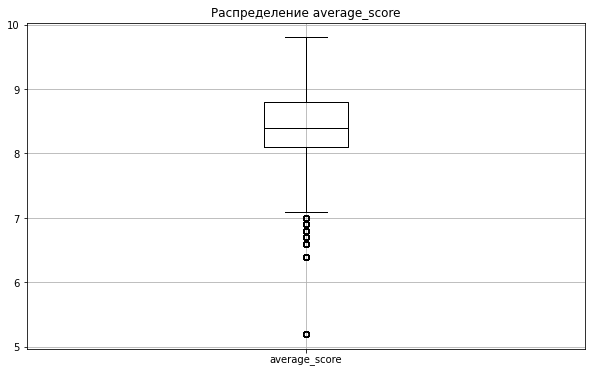

In [58]:
# распределение признака average_score
hotels['average_score'].plot(
    kind='box',
    figsize=(10, 6),
    title='Распределение average_score',
    grid = True,
    color = 'black'
);

# пометим выбросы, создав признак average_score_outliers
hotels['average_score_outliers'] = 0
mask = hotels['average_score'] < 6.5
hotels.loc[mask, 'average_score_outliers'] = 1

Мы видим, что значения признака содержат выбросы. Эмпирическим путем установлено, что если выбросами пометить значения менее 6.5, то метрика немного улучшается.

***
***

## 9. Дополнительная обработка отзывов ревьюверов.

Как ни крути, но это самые важные признаки, которые влияют на целевую переменную (это подтверждается логикой и экспериментами) и наша задача - найти способы их правильно обработать. 

### 9.1. Используем Affin и SentimentIntensityAnalyzer() (библиотека Vader). Код взят у [MOTOBORG RUS](https://www.kaggle.com/code/motoborgrus/proj-3-hotels/notebook?scriptVersionId=103790140)

In [59]:
# Формируется единый блок текста обеих частей отзыва и избавляемся от меток отсутствия слов:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('none', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('none', ''))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']


# Получаем очки оценки Afinn():
afinn = Afinn()
hotels['afinn_score'] = hotels['review'].apply(lambda x: afinn.score(x))

# Ограничиваются размеры диапазона значений по методу Тьюки:
def get_outliers_bonds(data, feature):
    """Определяем границы диапазонов для ограничения значений"""
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


lower_bound, upper_bound = get_outliers_bonds(hotels, 'afinn_score')

hotels['afinn_score'] = hotels['afinn_score'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# добавим контекст:
neg_words = {'small': -2, 'none': 10}
pos_words = {'none': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

# меняем метки отсутствия частей отзыва:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('none', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('none', 'Negative'))


hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
# hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
#     lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
# hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
#     lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])

### 9.2. Создадим признак **review_total_word_counts_diff_norm**, который будет представлять собой разницу в количестве слов негативного и позитивного отзыва.

Идея эта мне сразу пришла в голову и данный признак очень хорошо себя показал. Однако мои коллеги предложили его нормализовать, что поначалу меня удивило - получаемый признак имел красивое равноменое распределение. Однако практика показалу их правоту - нормализованный признак улучшает метрику. Кстати, вместо разницы можно использовать отношение, но практика показывает, что в такого рода признаках для метрики лучше все-таки разница.

In [60]:
mm_scaler = preprocessing.MinMaxScaler()

# нормализуем review_total_positive_word_counts
hotels['review_total_positive_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])
# нормализуем review_total_negative_word_counts
hotels['review_total_negative_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# оплучаем разницу и создаем искомый признак
hotels['review_total_word_counts_diff_norm'] = \
    hotels['review_total_positive_word_counts_norm'] - \
    hotels['review_total_negative_word_counts_norm']

# удалим исходные нормализованные признаки
hotels.drop(
    ['review_total_positive_word_counts_norm', 
     'review_total_negative_word_counts_norm'
     ], 
    axis=1, inplace=True)

### 9.3. Создадим новый признак **review_words_mean_ratio_norm**.

Тут я должен пояснить подробнее. Логически объяснить, почему я решил создать данный признак я внятно не могу, однако он улучшает метрику.  
Итак. Возьмем отзывы (сначала все негативные, затем все позитивные) и каждое слово закинем в список. Из этого списка создадим объект Counter - мы узнаем сколько каждое слово использовалось в отзывах данного типа (положительных или отрицательных). Затем преобразуем данный объект в словарь. Преобразуем отзыв - возьмем строку отзыва, заменим слова на частоту их встречаемости и вычислим среднее каждого отзыва. Затем вычтем разницу между положительным и отрицательным отзывом, нормализовав признаки.

In [61]:
review_words_list_neg =[] # словарь со словами в негативных отзывах

# пройдемся по негативным отзывам и заполним вышеуказанный словарь
for value in hotels.loc[:, 'negative_review']:
    value = value.split(' ')
    for i in range(len(value)):
        review_words_list_neg.append(value[i])
        

c_neg = Counter(review_words_list_neg) # получаем объект Counter
c_dict = dict(c_neg) # и преобразуем его в словарь

In [62]:
def get_words_mean(arg):
    '''
    функция получает строку отзыва, преобразует ее в список слов, 
    производит замену слов на частоту их встречаемости и возвращает
    среднее значение частоты встречаемости всех слов исходной строки
    '''
    arg_list = []
    arg = arg.split(' ')
    for i in range(len(arg)):
        word_num = c_dict[arg[i]]
        arg_list.append(word_num)
    
    return np.average(arg_list)

# создаем новый признак, применив нашу функцию
hotels['negative_review_words_mean'] = hotels['negative_review'].apply(get_words_mean)

Ниже, аналогично, производим те же манипуляции с позитивными отзывами

In [63]:
review_words_list_pos =[] # словарь со словами в позитивных отзывах

# пройдемся по позитивным отзывам и заполним вышеуказанный словарь
for value in hotels.loc[:, 'positive_review']:
    value = value.split(' ')
    for i in range(len(value)):
        review_words_list_pos.append(value[i])
        

c_pos = Counter(review_words_list_pos) # получаем объект Counter
c_dict = dict(c_pos) # и преобразуем его в словарь

In [64]:
# создаем новый признак, применив нашу функцию
hotels['positive_review_words_mean'] = hotels['positive_review'].apply(get_words_mean)

Теперь полученные признаки нормализуем и находим разницу, получив в итоге искомый признак.

In [65]:
mm_scaler = preprocessing.MinMaxScaler()

hotels['negative_review_words_mean_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['negative_review_words_mean'])),
    columns=['negative_review_words_mean'])

hotels['positive_review_words_mean_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['positive_review_words_mean'])),
    columns=['positive_review_words_mean'])

# получаем исходный признак
hotels['review_words_mean_ratio_norm'] = \
    hotels['negative_review_words_mean_norm'] - \
    hotels['positive_review_words_mean_norm']

hotels.drop(
    ['negative_review_words_mean_norm', 
     'positive_review_words_mean_norm'
     ], 
    axis=1, inplace=True)

### 9.4. Создадим признак **only_neg_pos_ratio_norm** - разница в количестве слов в негативном и позитивном отзыве, которые при этом встречаются **только** в негативных отзывах и **только** в позитивных.

У нас сохранились два списка - в одном все слова негативных отзывов, в другом - все слова в позитивных. Переведем их в множества, получив уникальные значения. Затем вычтем множества друг у друга, получив слова, которые встречаются только в одном из типов отзывов (негативных и позитивных). Считаем количество уникальных слов для данного типа отзыва (отрицательного и положительного) в каждом отзыве, а дальше, как обычно - получаем нормализованную разницу между ними.

In [66]:
# получаем множества из списков слов
set_neg = set(review_words_list_neg)
set_pos = set(review_words_list_pos)

# получаем разницу множеств
set_only_neg = set_neg - set_pos
set_only_pos = set_pos - set_neg

In [67]:
def get_only_negative(arg):
    '''
    функция получает негативный отзыв в виде строки и возвращает
    количество слов в данном отзыве, которые встречаются только
    в негативных отзывах
    '''
    negative_words_num = 0
    arg = arg.split(' ')
    for i in range(len(arg)):
        if arg[i] in set_only_neg:
            negative_words_num += 1
    
    return negative_words_num

def get_only_positive(arg):
    '''
    функция по сути дублирует предыдущую;
    функция получает позитивный отзыв в виде строки и возвращает
    количество слов в данном отзыве, которые встречаются только
    в позитивных отзывах
    '''
    positive_words_num = 0
    arg = arg.split(' ')
    for i in range(len(arg)):
        if arg[i] in set_only_pos:
            positive_words_num += 1
    
    return positive_words_num        

# применяем соответствующие функции к соответствующим признакам
hotels['only_negative'] = hotels['negative_review'].apply(get_only_negative)
hotels['only_positive'] = hotels['positive_review'].apply(get_only_positive)

In [68]:
# здесь мы вычислим нормализованную разницу между признаками,
# полученными выше

# последовательно нормализуем полученные признаки
mm_scaler = preprocessing.MinMaxScaler()

hotels['only_negative_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['only_negative'])),
    columns=['only_negative'])

hotels['only_positive_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['only_positive'])),
    columns=['only_positive'])

# считаем разницу
hotels['only_neg_pos_ratio_norm'] = \
    hotels['only_negative_norm'] - \
    hotels['only_positive_norm']

hotels.drop(
    ['only_negative_norm', 
     'only_positive_norm', 
     'only_negative',
     'only_positive'
     ], 
    axis=1, inplace=True)

***

## 10. Удалим признаки, которые уже точно нам не нужны.

In [69]:
hotels.drop([
    'hotel_city',
    'hotel_address',
    'review_date',
    'negative_review',
    'positive_review',
    'tags',
    'lat','lng'
], axis=1, inplace=True)

***

## 11. Кодирование категориальных признаков.

In [70]:
# котируем категориальные признаки, используя OneHotEncoding
encoder = ce.OneHotEncoder(cols=[ 
    'hotel_country',
    'review_month',
    'review_dayofweek',
    'tag_trip_type',
    'tag_guest_description'
    
]) 
# указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels[[
    'hotel_country',
    'review_month',
    'review_dayofweek',
    'tag_trip_type',
    'tag_guest_description'
]])
hotels = pd.concat([hotels, type_bin], axis=1)

In [71]:
# кодируем категориальные признаки, используя BinaryEncoding
bin_encoder = ce.BinaryEncoder(cols=[
    'hotel_region',
    'hotel_postcode',
    'hotel_name',
    'reviewer_nationality',
    'tag_room'

]) 
# указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels[[
    'hotel_region',
    'hotel_postcode',
    'hotel_name',
    'reviewer_nationality',
    'tag_room'
]])
hotels = pd.concat([hotels, type_bin], axis=1)

In [72]:
# удаляем исходные столбцы
hotels.drop([
    'hotel_country',
    'review_month',
    'review_dayofweek',
    'tag_trip_type',
    'tag_guest_description',
    
    'hotel_region',
    'hotel_postcode',
    'hotel_name',
    'reviewer_nationality',
    'tag_room'
], axis=1, inplace=True)

После кодирования мы удалили исходные признаки, однако нужно удалить еще оставшиеся признаки типа **object**

In [73]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
print(f'object columns: {object_columns}')
hotels.drop(object_columns, axis = 1, inplace=True)
print(f'Total deleted: {len(object_columns)}')

object columns: ['negative_review_temp', 'positive_review_temp', 'review', 'negative_review_sentiments', 'positive_review_sentiments']
Total deleted: 5


***

## 9. Отбор признаков

In [74]:
# сделаем копию датасета для удобства
hotels_copy = hotels.copy()

### 9.1. Оценим влияние признаков на целевую переменную и корреляцию. 

In [75]:
# так как таргет указан только в тренировочном датасете, 
# создадим соответствующую маску
mask = hotels_copy['sample'] == 1

In [76]:
# выделим категориальные признаки
hotels_cat = hotels_copy.drop([
    'reviewer_score',
    'sample',
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'review_total_word_counts_diff_norm',
    
    'review_words_mean_ratio_norm',
    'negative_review_words_mean',
    'positive_review_words_mean',
    
    'only_neg_pos_ratio_norm',
    
    
    'afinn_score',
    'n_review_sentiments_neg',
    'n_review_sentiments_compound',
    'p_review_sentiments_pos',
    'p_review_sentiments_compound',
    'n_review_sentiments_pos',
    'p_review_sentiments_neg',

 ], axis=1)
hotels_columns_cat = list(hotels_cat.columns)

In [77]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_copy[mask].drop(['reviewer_score'], axis = 1)  
y = hotels_copy[mask]['reviewer_score'] 
            
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

#### 9.1.1. Тест хи-квадрат.

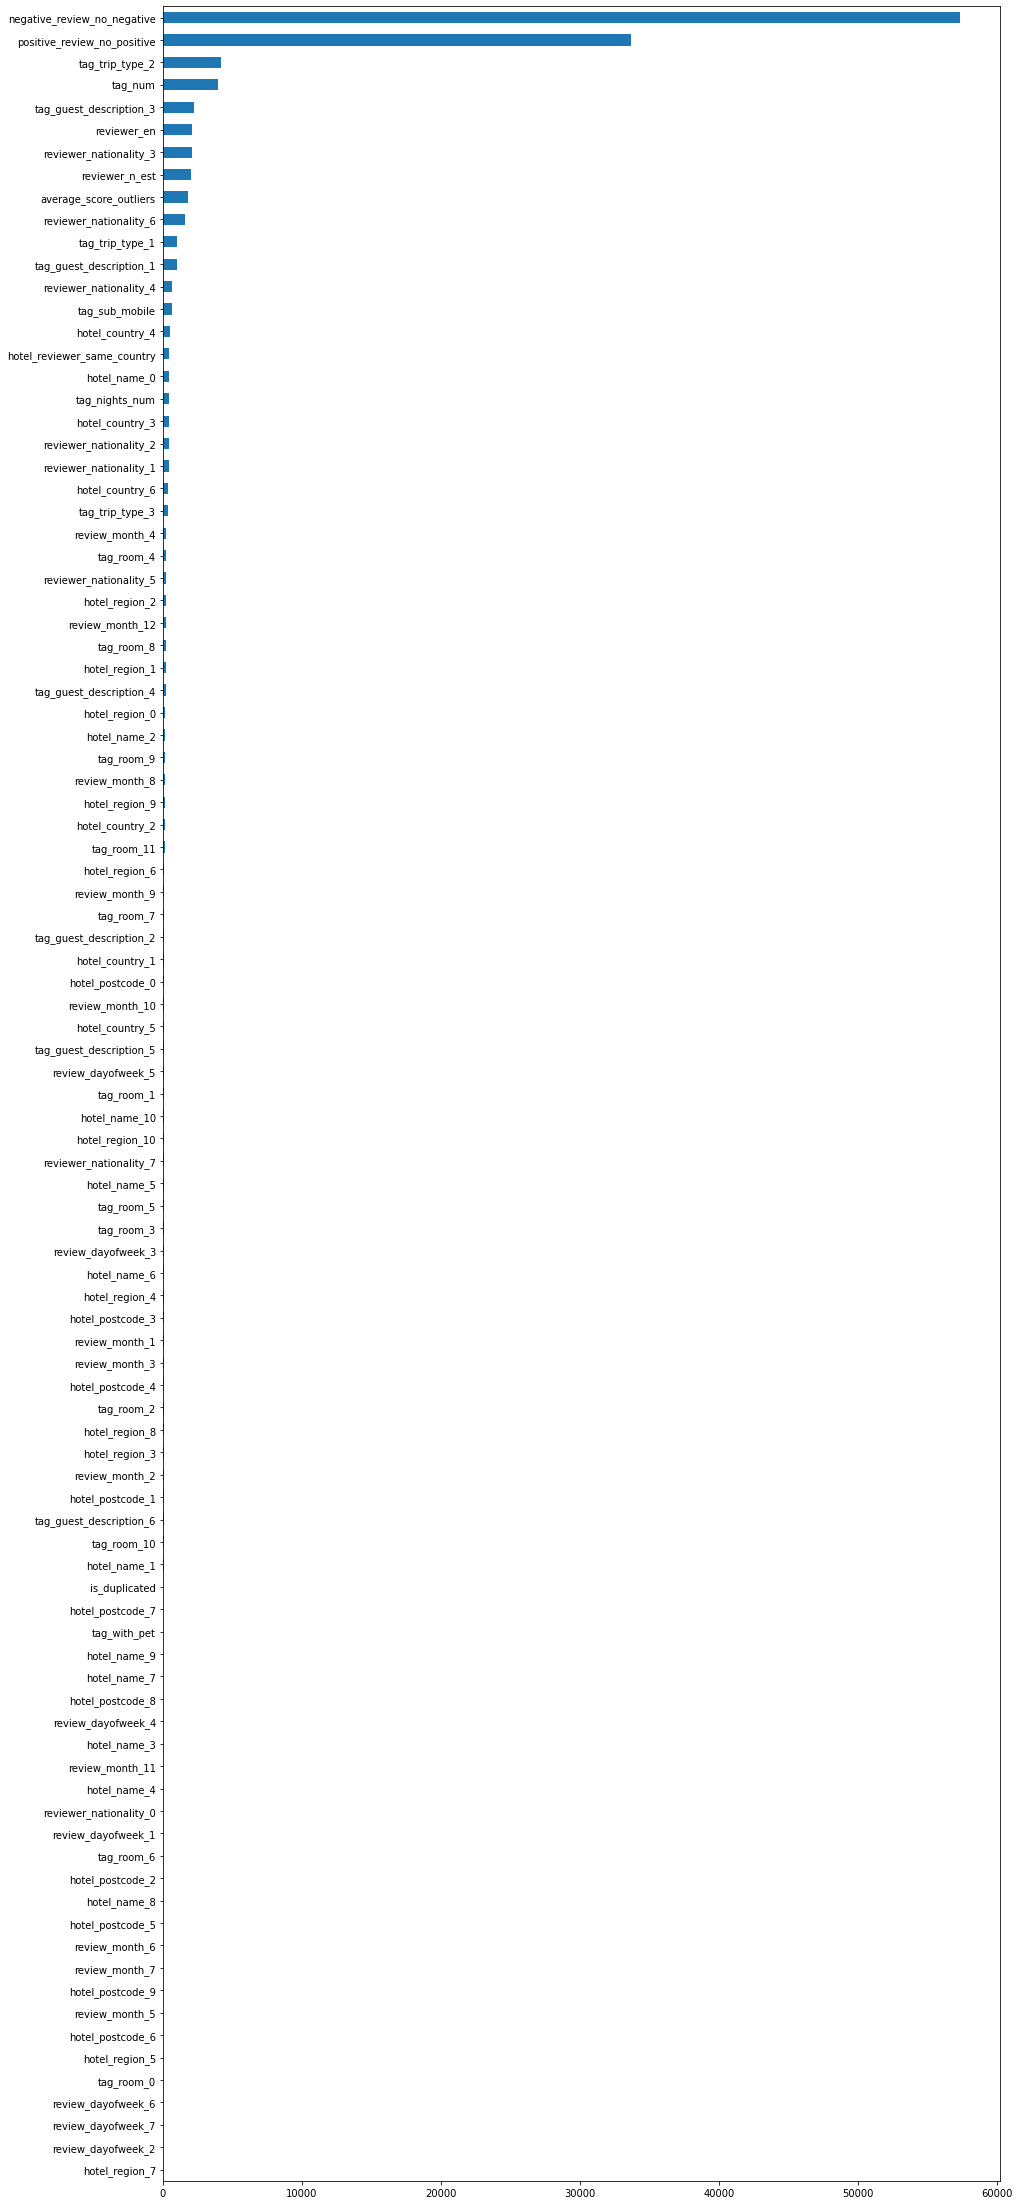

In [78]:
y=y.astype('int')

cat_cols = hotels_columns_cat

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(15, 40));

#### 9.1.2. Тест ANOVA.

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит изученный вами в юнитах по статистике анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

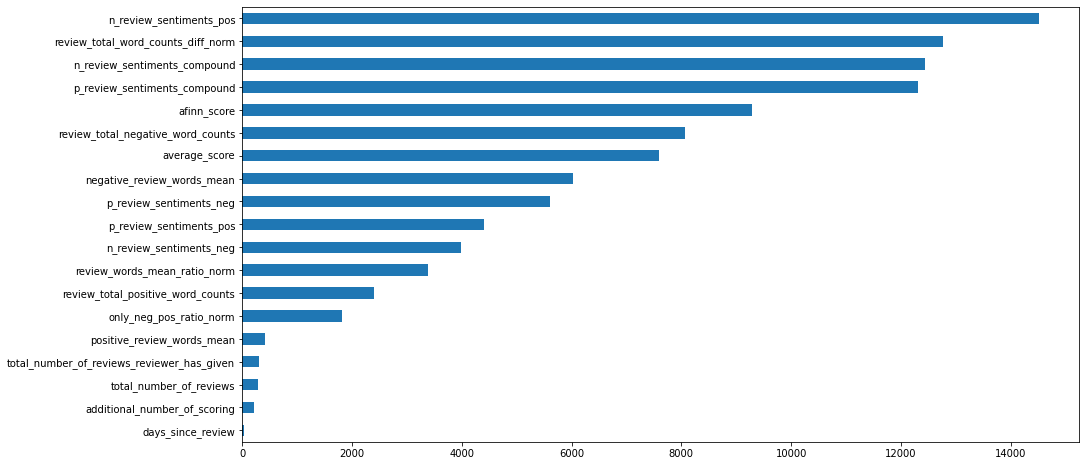

In [79]:
# выделим числовые признаки
num_cols = [
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'review_total_word_counts_diff_norm',
    
    'review_words_mean_ratio_norm',
    'negative_review_words_mean',
    'positive_review_words_mean',
    
    'only_neg_pos_ratio_norm',
    
    'afinn_score',
    'n_review_sentiments_neg',
    'n_review_sentiments_compound',
    'p_review_sentiments_pos',
    'p_review_sentiments_compound',
    'n_review_sentiments_pos',
    'p_review_sentiments_neg'
 ]

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', figsize=(15, 8));

#### 9.2. Корреляция.

Вместо создания тепловой матрицы выведем признаки с высокой степенью корреляции (мне так удобнее). Код взят с **stackoverflow.com**

In [80]:
# получим корреляцию Спирмена для категориальных признаков

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method = 'spearman').abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print('---')
print(get_top_abs_correlations(hotels_copy[mask], 20))

Top Absolute Correlations
---
tag_trip_type_1                    tag_trip_type_2                       0.904145
additional_number_of_scoring       total_number_of_reviews               0.859057
negative_review_no_negative        n_review_sentiments_pos               0.845433
tag_sub_mobile                     tag_num                               0.822977
afinn_score                        p_review_sentiments_compound          0.816375
review_total_negative_word_counts  negative_review_no_negative           0.805485
n_review_sentiments_pos            n_review_sentiments_compound          0.805329
negative_review_no_negative        negative_review_words_mean            0.766379
n_review_sentiments_neg            n_review_sentiments_compound          0.734532
positive_review_no_positive        p_review_sentiments_neg               0.718548
review_total_positive_word_counts  p_review_sentiments_compound          0.701447
review_total_negative_word_counts  review_total_word_counts_diff_nor

In [81]:
# получим корреляцию Пирсона для непрерывных признаков

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method='pearson').abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print('---')
print(get_top_abs_correlations(hotels_copy[mask], 20))

Top Absolute Correlations
---
positive_review_no_positive        p_review_sentiments_neg               0.987172
negative_review_no_negative        n_review_sentiments_pos               0.973486
tag_trip_type_1                    tag_trip_type_2                       0.904145
tag_sub_mobile                     tag_num                               0.838374
additional_number_of_scoring       total_number_of_reviews               0.824467
review_total_negative_word_counts  review_total_word_counts_diff_norm    0.770018
negative_review_no_negative        negative_review_words_mean            0.753067
n_review_sentiments_pos            n_review_sentiments_compound          0.732451
positive_review_words_mean         review_words_mean_ratio_norm          0.725361
n_review_sentiments_pos            negative_review_words_mean            0.719885
p_review_sentiments_neg            p_review_sentiments_compound          0.713026
p_review_sentiments_pos            p_review_sentiments_compound     

#### 9.3. Удалим признаки мало влияющие на таргет или сильно коррелирующие.

In [82]:
hotels_copy.drop([
    
    
], axis=1, inplace=True)

**Примечание:** Практика показала, что уменьшение количества признаков как правило ухудшает метрику. Исключение - признаки со степенью корреляции 1. Решил все оставить.

***

## 10. Работа с моделью.

In [83]:
# Теперь выделим тестовую часть
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [84]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [85]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 117), (386803, 117), (386803, 116), (309442, 116), (77361, 116))

In [86]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [87]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished


In [88]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 4))

MAE: 0.8503394475252385
MAPE: 12.1268


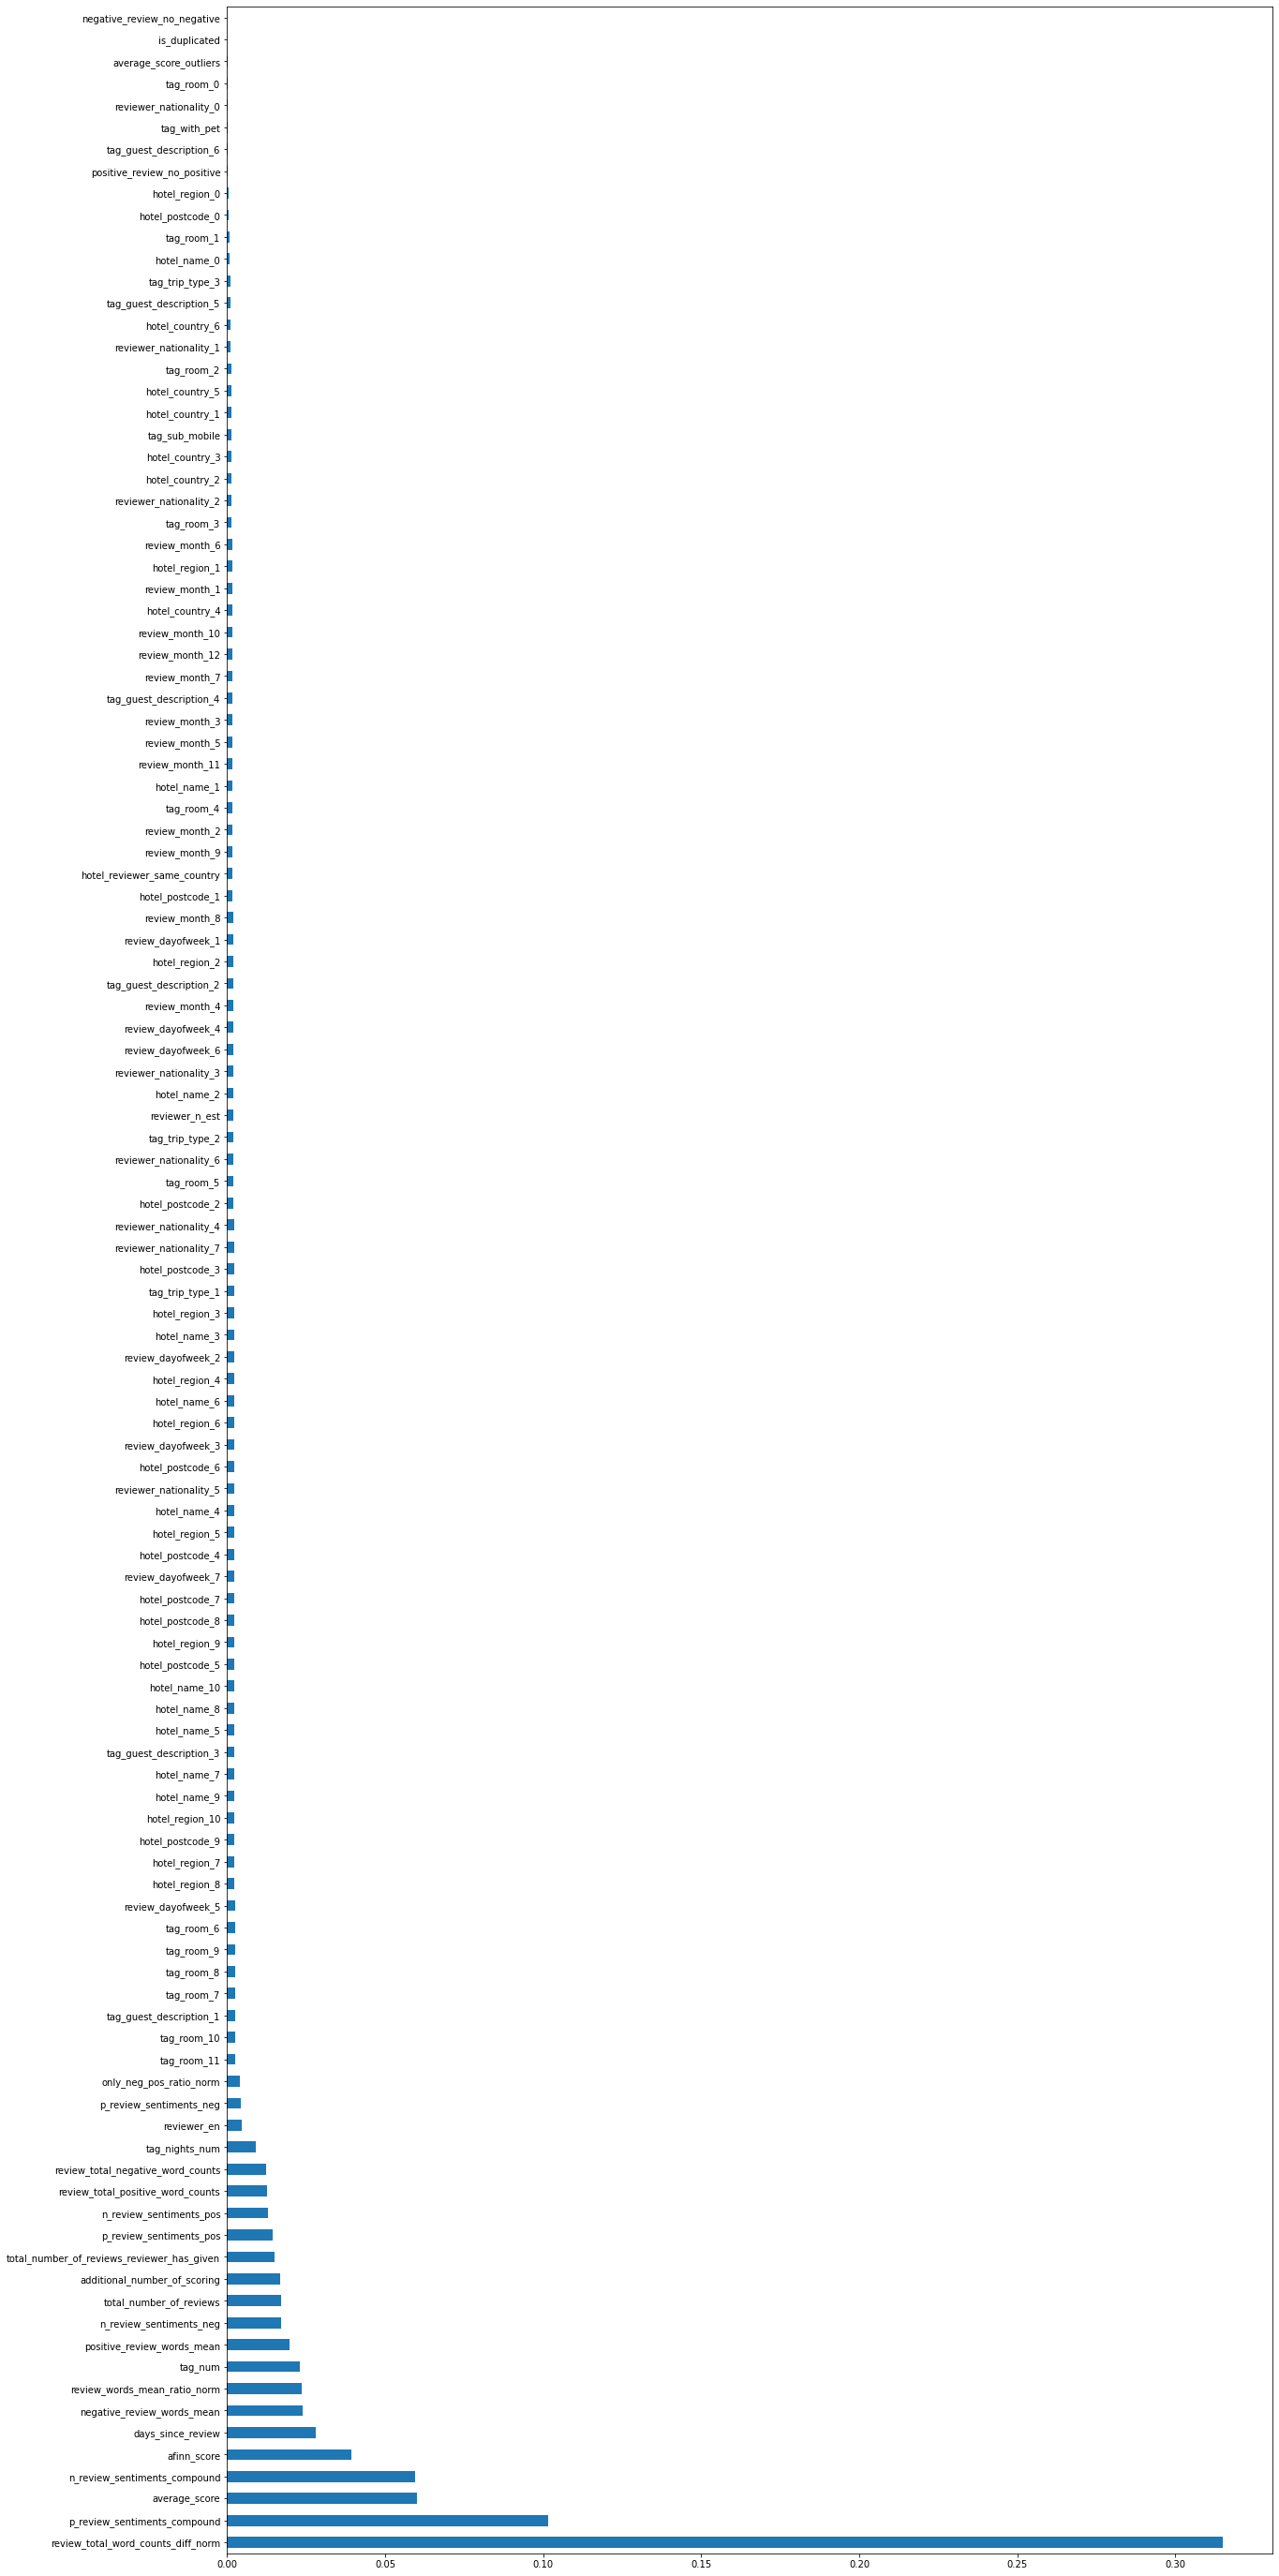

In [89]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,50)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(feat_importances)).plot(kind='barh');


In [90]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,is_duplicated,hotel_reviewer_same_country,...,tag_room_2,tag_room_3,tag_room_4,tag_room_5,tag_room_6,tag_room_7,tag_room_8,tag_room_9,tag_room_10,tag_room_11
117473,791,7.3,83,3609,1,2,172,0.0,0,1,...,0,0,0,0,1,1,1,1,1,1
46066,459,8.4,14,2405,4,11,299,0.0,0,1,...,0,0,0,0,0,0,0,1,1,1
90695,32,8.8,1,267,55,9,109,0.0,0,0,...,1,0,0,0,0,1,1,1,1,0
112541,299,8.3,5,1361,1,3,564,0.0,0,1,...,0,0,0,0,0,0,1,1,0,1
82784,282,8.6,6,2875,17,59,730,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
18771,1471,9.1,68,4802,13,1,27,0.0,0,1,...,0,0,0,0,1,0,1,0,1,1
63075,69,8.3,31,896,18,3,591,0.0,0,0,...,0,0,0,0,0,0,0,1,0,1
25872,908,8.5,1,3980,11,1,100,0.0,0,0,...,0,1,0,1,1,1,0,0,1,1
113169,184,7.9,1,564,57,3,283,0.0,0,0,...,0,0,1,0,0,1,1,0,1,0
124040,148,7.8,40,1245,28,2,132,0.0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [91]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [92]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [93]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished


In [94]:
predict_submission

array([8.674, 7.531, 8.035, ..., 8.141, 9.537, 7.683])

In [95]:
list(sample_submission)

['reviewer_score', 'id']

In [96]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.674,488440
1,7.531,274649
2,8.035,374688
3,9.780,404352
4,9.497,451596
5,8.976,302161
6,8.039,317079
7,7.826,13963
8,8.063,159785
9,7.579,195089


***

**Выводы по проекту:**
- из первоначальных числовых признаков наиболее важный - **average_score** и количество слов в положительных и отрицательных отзывах.
- из категориальных - собственно отзывы, а, точнее, производные из них признаки, связанные с анализом этих отзывов.
- неожиданно (для меня) неплохой прирост метрики дали признаки, которые содержали информацию откуда родом ревьюверы: из англоязычных стран, из ближневосточных мусульманских или остальных.
- интересно было бы посмотреть код победителей соревнований, но полагаю, что там был выполнен более серьезный и глубокий анализ текста отзывов.
- некоторые решения моих коллег не улучшали мою метрику, например сигнальный признак о посещении отеля в пик сезона и пр.
- любые мои попытки обработать таргет (даже только в тренировочной части датасета) очень сильно **улучшали мою метрику**, однако очень сильно **ухудшали очки по сабмишину** :( 